In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
!fuser -k /content/drive/MyDrive/IoT_project/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list -s "CIC-IDS-2017"


In [ ]:
!kaggle datasets download -d chethuhn/network-intrusion-dataset -p /content


In [ ]:
!unzip -q /content/network-intrusion-dataset.zip -d /content/network_intrusion
!ls /content/network_intrusion

In [ ]:
!mkdir -p "/content/MyDrive/MyDrive/IoT_project/project_main/data_csv"
!cp -r /content/network_intrusion/* "/content/MyDrive/MyDrive/IoT_project/project_main/data_csv/"


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/IoT_project/project_main/data_csv/Wednesday-workingHours.pcap_ISCX.csv"
df = pd.read_csv(path)
df.head()

# Подготовка на данните

**Зареждане на данните**

In [ ]:
import glob
import pandas as pd

path = "/content/drive/MyDrive/IoT_project/project_main/data_csv"
all_files = glob.glob(path + "/*.csv")

df_raw = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
print("Raw rows:", df_raw.shape[0])
df_raw.head()


Raw rows: 2830743


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


**Трансформация на таргет стойностите (типове Атаки)**

In [ ]:
def simplify_label(label):
    label = str(label).lower()

    if 'dos' in label and 'ddos' not in label: return 'DoS'
    if 'ddos' in label: return 'DDoS'
    if 'portscan' in label: return 'PortScan'
    if 'webattack' in label: return 'WebAttack'
    if 'infiltration' in label: return 'Infiltration'
    if label == 'benign': return 'BENIGN'
    return 'Other'

df_raw["Label_simple"] = df_raw[" Label"].apply(simplify_label)
df_raw["Label_simple"].value_counts()

,count
Label_simple,
BENIGN,2273097
DoS,252661
PortScan,158930
DDoS,128027
Other,17992
Infiltration,36


**Визуализация на типовете атаки (с изкл. на BENIGN)**

/tmp/ipython-input-4046768276.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label_simple', data=attack_data,


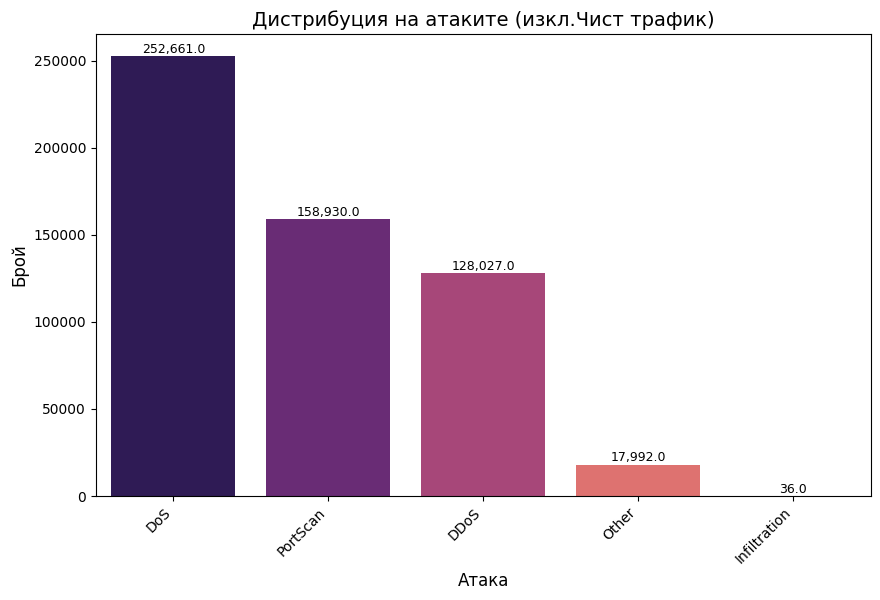

In [ ]:
# Plot the distribution of the grouped 'Attack_Type' (excluding Benign for attack focus)
attack_data = df_raw[df_raw['Label_simple'] != 'BENIGN']

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Label_simple', data=attack_data,
                     order=attack_data['Label_simple'].value_counts().index,
                     palette='magma')
plt.title('Дистрибуция на атаките (изкл.Чист трафик)', fontsize=14)
plt.xlabel('Атака', fontsize=12)
plt.ylabel('Брой', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  fontsize=9, color='black',
                  xytext=(0, 5),
                  textcoords='offset points')

**Селектиране на предикторите**

In [ ]:
df_raw_features=df_raw.iloc[:, :-2]

**Селектиране на таргета**

In [ ]:
df_raw_target=df_raw.iloc[:, -1]

In [ ]:
df_raw_features.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


**Премахване на екстремните стойности**

In [ ]:
df_raw_features = df_raw_features.clip(lower=df_raw_features.quantile(0.01), upper=df_raw_features.quantile(0.99), axis=1)

In [ ]:
df_raw_features.shape

(2830743, 78)

In [ ]:
for c in df_raw_features.columns:
    col = df_raw_features[c]
    if np.isinf(col).any() or (np.abs(col) > 1e100).any():
        print(c, col.max(), col.min())

In [ ]:
df_raw_features = df_raw_features.replace([np.inf, -np.inf], np.nan)

**Селекция на предиктори**

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# 1. Create the selector
vt = VarianceThreshold(threshold=1e-4)

# 2. Fit on your original DataFrame
vt.fit(df_raw_features)

# 3. Boolean mask of features that survived
mask = vt.get_support()
print(mask)  # e.g., [ True, False, True, True, False ... ]


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False False  True  True  True  True  True False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [ ]:
selected_columns = df_raw_features.columns[mask].tolist()
print(selected_columns)
print(len(selected_columns))


[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' Down/Up Ratio', ' Average Packet Size', ' Avg Fwd Segment Size'

# Данните с нормална дистрибуция ли са?

**Проверка на дистрибуционните стойности**

In [ ]:
from scipy.stats import skew

# For all PCs in a DataFrame df_pca
skew_values=df_raw_features.apply(skew)
print(skew_values)

 Destination Port              2.066590
 Flow Duration                 2.153847
 Total Fwd Packets             3.650492
 Total Backward Packets        4.337714
Total Length of Fwd Packets    6.220137
                                 ...   
 Active Min                    7.676632
Idle Mean                      3.047496
 Idle Std                      8.764090
 Idle Max                      2.935151
 Idle Min                      3.167127
Length: 78, dtype: float64


**Скалиране на данните**

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_scaled_ = pt.fit_transform(df_raw_features)


In [ ]:
# Convert NumPy array to DataFrame
df_scaled_ = pd.DataFrame(df_scaled_, columns=df_raw_features.columns, index=df_raw_features.index)  # keep the same index as y

In [ ]:
df_scaled_

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1.667532,-1.624105,-0.232150,-1.649032,-0.561643,-1.346765,-0.693698,0.329452,-0.662487,-0.715734,...,0.115199,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
1,1.667807,-0.956736,-1.307029,-0.443293,-0.820210,-0.716371,-0.693698,0.329452,-0.662487,-0.715734,...,-1.200629,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
2,1.667808,-1.101209,-1.307029,-0.443293,-0.820210,-0.716371,-0.693698,0.329452,-0.662487,-0.715734,...,-1.200629,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
3,1.653397,-1.183948,-1.307029,-0.443293,-0.820210,-0.716371,-0.693698,0.329452,-0.662487,-0.715734,...,-1.200629,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
4,1.667529,-1.624105,-0.232150,-1.649032,-0.561643,-1.346765,-0.693698,0.329452,-0.662487,-0.715734,...,0.115199,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,-0.920139,0.119544,0.661671,0.117888,0.367407,0.237087,-0.024900,1.042901,0.203716,-0.715734,...,0.969160,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
2830739,-0.920139,-0.745005,-0.232150,0.117888,0.242741,0.494441,0.163169,1.210424,0.472097,-0.715734,...,0.115199,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
2830740,1.671973,-1.012291,-0.232150,-0.443293,-0.179566,-0.716371,0.021988,-0.995746,-0.158355,1.200671,...,-1.200629,0.983817,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624
2830741,-0.920139,0.739696,1.059330,0.117888,0.603728,0.392075,0.036660,1.099166,0.290309,-0.715734,...,1.321977,-0.978116,-0.492592,-0.27979,-0.492351,-0.492649,-0.500624,-0.296848,-0.500624,-0.500624


**Повторна проверка на дистрибуционните стойности след скалирането на данните**

In [ ]:
# For all PCs in a DataFrame df_pca
skew_values_after_scaling=df_scaled_.apply(skew)
print(skew_values_after_scaling)

 Destination Port              0.494597
 Flow Duration                 0.031172
 Total Fwd Packets             0.274261
 Total Backward Packets        0.058390
Total Length of Fwd Packets   -0.007944
                                 ...   
 Active Min                    1.555451
Idle Mean                      1.496905
 Idle Std                      3.071919
 Idle Max                      1.496906
 Idle Min                      1.496907
Length: 78, dtype: float64


**Премахване на колоните с високи дистрибуционни стойности**

In [ ]:
# Assume skew_values_after_scaling is a pandas Series
high_skew = skew_values_after_scaling[skew_values_after_scaling.abs() > 2]
print(high_skew)

Fwd PSH Flags      4.310322
FIN Flag Count     5.030052
 SYN Flag Count    4.310322
 URG Flag Count    2.765990
 Active Std        3.294625
 Idle Std          3.071919
dtype: float64


In [ ]:
# Count missing values per column
missing_counts = df_scaled_.isna().sum()
print(missing_counts[missing_counts > 0])


Flow Bytes/s    1358
dtype: int64


**Премахване на липсващи стойности**

In [ ]:
df_scaled_ = df_scaled_.dropna()

In [ ]:
df_raw_features=df_raw_features.dropna()

**Principal Component Analysis**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
df_pca=pca.fit_transform(df_scaled_)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.49135769 0.14085916 0.06369475 0.05602532 0.03947684 0.03373706
 0.0254572  0.02173445 0.02078762 0.01767039]
[9578.18528736 5128.34109811 3448.54724389 3234.27188994 2714.91065379
 2509.79334195 2180.16647845 2014.46016625 1970.09314306 1816.38292298]


In [ ]:
n_components = df_pca.shape[1]
pca_columns = [f'PC{i+1}' for i in range(n_components)]


In [ ]:
df_pca = pd.DataFrame(df_pca, columns=pca_columns, index=df_raw_features.index)


In [ ]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-6.211171,-1.913361,0.776578,-2.544923,1.036040,-1.635979,1.124364,-0.758396,-1.700812,-0.979349
1,-6.202926,-0.321981,0.454782,2.471071,1.965895,1.278918,0.594257,-2.285024,-0.199118,-1.166435
2,-6.306884,-0.247639,0.712990,2.390462,2.106855,1.072693,0.730773,-2.303878,-0.181967,-1.164475
3,-6.359291,-0.211533,0.870624,2.350086,2.186183,0.959613,0.814085,-2.318067,-0.165443,-1.170999
4,-6.211489,-1.911983,0.775119,-2.545239,1.036256,-1.636535,1.125497,-0.758519,-1.700118,-0.979182
...,...,...,...,...,...,...,...,...,...,...
2830738,0.326937,1.760951,-0.957932,-2.090347,-1.679781,-1.082820,0.404014,-0.700961,0.877094,-0.940607
2830739,-1.712327,4.518201,0.365645,-0.557903,0.576659,-1.090940,0.642454,-0.434995,-0.135117,-0.159030
2830740,-3.608311,-1.414838,2.561507,-3.644225,4.371710,2.513284,-0.909827,1.286246,1.792140,1.909299
2830741,1.746877,1.542697,-1.820264,-2.506764,-2.333548,-0.578927,0.457890,-0.338065,1.260697,-1.704232


In [ ]:
df_final = pd.concat([df_pca,df_raw_target], axis=1)

In [ ]:
df_final=df_final.dropna()

In [ ]:
df_final

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Label_simple
0,-6.211171,-1.913361,0.776578,-2.544923,1.036040,-1.635979,1.124364,-0.758396,-1.700812,-0.979349,BENIGN
1,-6.202926,-0.321981,0.454782,2.471071,1.965895,1.278918,0.594257,-2.285024,-0.199118,-1.166435,BENIGN
2,-6.306884,-0.247639,0.712990,2.390462,2.106855,1.072693,0.730773,-2.303878,-0.181967,-1.164475,BENIGN
3,-6.359291,-0.211533,0.870624,2.350086,2.186183,0.959613,0.814085,-2.318067,-0.165443,-1.170999,BENIGN
4,-6.211489,-1.911983,0.775119,-2.545239,1.036256,-1.636535,1.125497,-0.758519,-1.700118,-0.979182,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...
2830738,0.326937,1.760951,-0.957932,-2.090347,-1.679781,-1.082820,0.404014,-0.700961,0.877094,-0.940607,BENIGN
2830739,-1.712327,4.518201,0.365645,-0.557903,0.576659,-1.090940,0.642454,-0.434995,-0.135117,-0.159030,BENIGN
2830740,-3.608311,-1.414838,2.561507,-3.644225,4.371710,2.513284,-0.909827,1.286246,1.792140,1.909299,BENIGN
2830741,1.746877,1.542697,-1.820264,-2.506764,-2.333548,-0.578927,0.457890,-0.338065,1.260697,-1.704232,BENIGN


In [ ]:
df_final.to_csv("/content/drive/MyDrive/IoT_project/project_main/data_csv/pca_with_labels.csv",
              index=False)

**Корелационна матрица след PCA**

In [ ]:
df_numeric = df_pca.select_dtypes(include=['number'])
corr = df_numeric.corr()

In [ ]:
corr.to_csv("/content/drive/MyDrive/IoT_project/project_main/results/correlation_matrix.csv")
print("Saved")

Saved


In [ ]:
import matplotlib.pyplot as plt


labels = df_pca["Label_simple"].astype("category")
colors = labels.cat.codes

plt.figure(figsize=(10, 7))

plt.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    c=colors,
    cmap="tab10",
    alpha=0.6,
    s=10
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot (PC1 vs PC2)")
plt.colorbar(label="Label (encoded)")
plt.show()


In [ ]:
corr

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of PCA Components")
plt.show()

**Корелационна матрица преди PCA**

In [ ]:

# КОРЕЛАЦИОННА МАТРИЦА ПРЕДИ PCA

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

BASE_DIR = "/content/drive/MyDrive/project_main"
DATA_DIR = f"{BASE_DIR}/data_csv"
RES_DIR  = f"{BASE_DIR}/results"

os.makedirs(RES_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)

import glob
print("Файлове в data_csv:")
print(glob.glob(DATA_DIR + "/*.csv"))

file_path = f"{DATA_DIR}/Wednesday-workingHours.pcap_ISCX.csv"

df_raw = pd.read_csv(file_path, nrows=50000)

df_raw = df_raw.replace([np.inf, -np.inf], np.nan)
df_raw = df_raw.dropna()

df_numeric_before = df_raw.select_dtypes(include="number")

corr_before = df_numeric_before.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_before, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix BEFORE PCA (subset)")
plt.tight_layout()
plt.show()

output_path = f"{RES_DIR}/corr_before_pca_subset.csv"
corr_before.to_csv(output_path)
print("Корелационната матрица преди PCA:", output_path)


KeyboardInterrupt: 